In [1]:
#@title Run to install MuJoCo and `dm_control`
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# print('Installing dm_control...')
# !pip install -q dm_control>=1.0.18

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite

!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

Wed Sep  4 13:21:33 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:4B:00.0 Off |                  Off |
|  0%   29C    P8             20W /  450W |      27MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70

    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    # fig, ax = plt.subplots(1, 1, figsize=(scaled_width / dpi, scaled_height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

Define Environment

In [3]:
import numpy as np
from dm_control import viewer
from env import mice_env
# from spine import prototype

/home/zhangzhibo/anaconda3/envs/mujoco/lib/python3.9/site-packages/glfw/__init__.py:914: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


Main Loop

In [5]:
env = mice_env.rodent_maze_forage()
action_spec = env.action_spec()
time_step = env.reset()

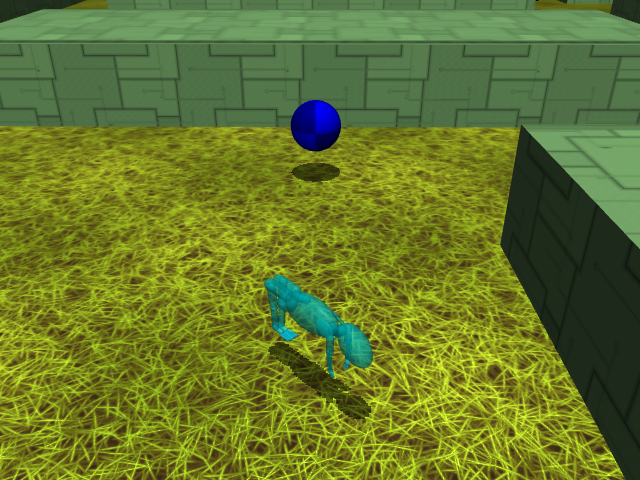

In [6]:
frame_size = {'width': 640, 'height': 480}
pixels = env.physics.render(camera_id=1,**frame_size)
PIL.Image.fromarray(pixels)

In [9]:
def random_policy(time_step):
    # Generates random actions within the specified range
    action = 0.01 * np.random.uniform(action_spec.minimum, action_spec.maximum,
                               size=action_spec.shape)
    # print("reward = {}, discount = {}, observations = {}.".format(
    #   time_step.reward, time_step.discount, time_step.observation))
    return np.clip(action, action_spec.minimum, action_spec.maximum)

# Launch the viewer to visualize the environment
# viewer.launch(env, policy=random_policy)

In [7]:
def custom_policy(time_step):
    # Access the current positions and velocities
    qpos = env.physics.data.qpos[7:]
    qvel = env.physics.data.qvel[6:]

    # Define desired positions and velocities (for simplicity, assume you want to maintain the current position)
    desired_qpos = np.zeros_like(qpos)
    desired_qvel = np.zeros_like(qvel)

    # Proportional-Derivative control gains
    Kp = 0.1
    Kd = 0.01

    # PD control to compute actuator commands
    position_error = desired_qpos - qpos
    velocity_error = desired_qvel - qvel
    control_signal = 0.01*(Kp * position_error + Kd * velocity_error)

    # Clip the control signal to the action specification limits
    action = np.clip(control_signal, action_spec.minimum, action_spec.maximum)

    return action

In [9]:
#@title Video of the movement{vertical-output: true}
#@test {"timeout": 600}

duration = 10   # (Seconds)
framerate = 30  # (Hz)
video = []

# Control signal frequency, phase, amplitude.
freq = 5
amp = 0.9


# Simulate, saving video frames and torso locations.
env.physics.reset()
while env.physics.data.time < duration:
  # Inject controls and step the physics.
  action = custom_policy(time_step)
  time_step = env.step(action)

  # Save video frames.
  if len(video) < env.physics.data.time * framerate:
    pixels = env.physics.render(camera_id=1,**frame_size)
    video.append(pixels.copy())

display_video(video, framerate)

/tmp/ipykernel_2490565/2502673715.py:46: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed in 3.10.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use(orig_backend)  # Switch back to the original backend.
